In [1]:
# import libraries
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from unityagents import UnityEnvironment

In [2]:
# import libraries
import agent
import config
from util import utils

In [3]:
# init
utils.seed_everything()
os.makedirs(config.SAVE_DIRECTORY, exist_ok=True)

In [4]:
# load game environment
env = UnityEnvironment(file_name=config.UNITY_ENVIRONMENT_PATH)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
# extract game configuration
num_agents = len(env_info.agents)
states = env_info.vector_observations
input_dims = states.shape[1]
action_dims = brain.vector_action_space_size

In [6]:
# initialise agent
agent = agent.DDPG(input_dims, action_dims, num_agents)

In [7]:
# create training function
def train(n_episodes, num_agents, score_buffer=100):

    # init
    scores_log = []
    scores_deque = deque(maxlen=100)
    best_average_score = 0

    # start training
    for eps in range(n_episodes):

        # re-init
        agent.reset()
        score = np.zeros(num_agents)

        # reset env
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        # iterating within single episode
        while True:

            # get optimal actions based on latest agent policy
            actions = agent.act(states)
        
            # execute actions
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            # learn from actions
            agent.step(states, actions, rewards, next_states, dones)

            # store rewards
            score += rewards
        
            # stop iteration if it reach terminal                                                        
            if np.any(dones):   
                break                                        

            # setting preparation for next iteration
            states = next_states       

        # calculate average score from all agents
        average_episode_score = np.mean(score)
        
        # save score into buffer
        scores_log.append(average_episode_score)
        scores_deque.append(average_episode_score)

        # save better model
        average_score = np.mean(scores_deque)
        if average_score > best_average_score:
            torch.save(agent.actor_local.state_dict(), '{}/actor_model.pth'.format(config.SAVE_DIRECTORY))
            torch.save(agent.critic_local.state_dict(), '{}/critic_model.pth'.format(config.SAVE_DIRECTORY))
            best_average_score = average_score
            if best_average_score > 30:
                print("environment solved in {} episode with average score = {}".format(eps, best_average_score))
                break
        print("episode: {}/{}   score: {}   best score: {}".format(eps, n_episodes, np.mean(score), best_average_score), end="\r")
    
    return scores_log

# start training
scores_log = train(config.N_EPISODES, num_agents)

/home/junkit2/.local/lib/python3.6/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


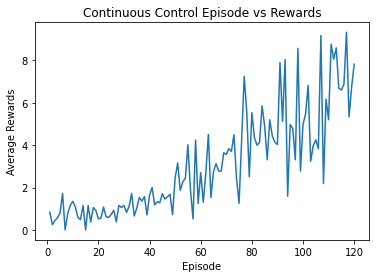

In [8]:
# plot results
x = np.arange(1, len(scores_log)+1)
y = scores_log
plt.plot(x, y)
plt.title("Continuous Control Episode vs Rewards")
plt.xlabel("Episode")
plt.ylabel("Average Rewards")
plt.show()